<a href="https://colab.research.google.com/github/DataBioExplorer/Calculo_metricas/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import urllib.request

# Definir URL e caminhos
url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
base_dir = "datasets"
zip_file = os.path.join(base_dir, "gatos-e-cachorros.zip")
extract_dir = os.path.join(base_dir, "PetImages")

# Criar o diretório base, se não existir
os.makedirs(base_dir, exist_ok=True)

# Baixar o arquivo ZIP se ele não existir
if not os.path.exists(zip_file):
    print("Baixando o dataset...")
    urllib.request.urlretrieve(url, zip_file)
    print("Download concluído!")
else:
    print("O arquivo ZIP já existe.")

# Extrair o arquivo ZIP se o diretório de extração não existir
if not os.path.exists(extract_dir):
    print("Extraindo o dataset...")
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(base_dir)
    print("Extração concluída!")
else:
    print("O dataset já foi extraído.")

# Definir os diretórios de gatos e cachorros
cat_dir = os.path.join(extract_dir, "Cat")
dog_dir = os.path.join(extract_dir, "Dog")

# Verificar se os diretórios existem
if not os.path.exists(cat_dir):
    print("Erro: Diretório de gatos não encontrado!")
else:
    print("Diretório de gatos encontrado.")

if not os.path.exists(dog_dir):
    print("Erro: Diretório de cachorros não encontrado!")
else:
    print("Diretório de cachorros encontrado.")

# Contar e exibir o número de imagens em cada diretório
if os.path.exists(cat_dir):
    cat_images = len([f for f in os.listdir(cat_dir) if os.path.getsize(os.path.join(cat_dir, f)) > 0])
    print(f"Número de imagens de gatos: {cat_images}")

if os.path.exists(dog_dir):
    dog_images = len([f for f in os.listdir(dog_dir) if os.path.getsize(os.path.join(dog_dir, f)) > 0])
    print(f"Número de imagens de cachorros: {dog_images}")

Baixando o dataset...
Download concluído!
Extraindo o dataset...
Extração concluída!
Diretório de gatos encontrado.
Diretório de cachorros encontrado.
Número de imagens de gatos: 12500
Número de imagens de cachorros: 12500


In [2]:
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Função para dividir os dados entre treino e teste
def dividir_dados(origem, treino, teste, proporcao):
    """
    Move arquivos do diretório de origem para os diretórios de treino e teste
    de acordo com a proporção especificada.
    """
    # Cria os diretórios de destino caso não existam
    os.makedirs(treino, exist_ok=True)
    os.makedirs(teste, exist_ok=True)

    # Obtém todos os arquivos válidos (com tamanho > 0)
    arquivos = [f for f in os.listdir(origem) if os.path.getsize(os.path.join(origem, f)) > 0]

    if not arquivos:
        raise ValueError(f"Nenhum arquivo encontrado em {origem}.")

    # Embaralha a lista de arquivos
    random.shuffle(arquivos)

    # Determina quantos arquivos irão para o conjunto de treino
    tamanho_treino = int(len(arquivos) * proporcao)
    conjunto_treino = arquivos[:tamanho_treino]
    conjunto_teste = arquivos[tamanho_treino:]

    # Copia os arquivos para os diretórios correspondentes
    for arquivo in conjunto_treino:
        shutil.copyfile(os.path.join(origem, arquivo), os.path.join(treino, arquivo))
    for arquivo in conjunto_teste:
        shutil.copyfile(os.path.join(origem, arquivo), os.path.join(teste, arquivo))

    print(f"Dados divididos: {len(conjunto_treino)} para treino e {len(conjunto_teste)} para teste.")

# Definindo os diretórios (ajuste os caminhos se necessário)
DIR_GATOS_ORIGEM = "/tmp/PetImages/Cat/"
DIR_GATOS_TREINO = "/tmp/gatos-vs-cachorros/treino/gatos/"
DIR_GATOS_TESTE = "/tmp/gatos-vs-cachorros/teste/gatos/"

DIR_CACHORROS_ORIGEM = "/tmp/PetImages/Dog/"
DIR_CACHORROS_TREINO = "/tmp/gatos-vs-cachorros/treino/cachorros/"
DIR_CACHORROS_TESTE = "/tmp/gatos-vs-cachorros/teste/cachorros/"

# Dividir os dados (usando 90% para treino)
dividir_dados(DIR_GATOS_ORIGEM, DIR_GATOS_TREINO, DIR_GATOS_TESTE, 0.9)
dividir_dados(DIR_CACHORROS_ORIGEM, DIR_CACHORROS_TREINO, DIR_CACHORROS_TESTE, 0.9)

# Criando o modelo de rede neural
modelo = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

modelo.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
print("Modelo compilado.")

# Diretórios para os geradores de dados
DIR_TREINO = "/tmp/gatos-vs-cachorros/treino/"
DIR_TESTE = "/tmp/gatos-vs-cachorros/teste/"

# Configuração dos geradores de dados (redimensionando as imagens e normalizando os pixels)
gerador_treino = ImageDataGenerator(rescale=1.0/255.)
gerador_validacao = ImageDataGenerator(rescale=1.0/255.)

gerador_treino = gerador_treino.flow_from_directory(
    DIR_TREINO,
    batch_size=250,
    class_mode='binary',
    target_size=(150, 150)
)

gerador_validacao = gerador_validacao.flow_from_directory(
    DIR_TESTE,
    batch_size=250,
    class_mode='binary',
    target_size=(150, 150)
)

# Treinamento do modelo
historico = modelo.fit(
    gerador_treino,
    epochs=10,
    steps_per_epoch=100,
    validation_data=gerador_validacao,
    validation_steps=6
)

# Plotando as métricas de treinamento
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(historico.history['accuracy'], label='Acurácia Treino')
plt.plot(historico.history['val_accuracy'], label='Acurácia Validação')
plt.title('Acurácia por Época')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(historico.history['loss'], label='Perda Treino')
plt.plot(historico.history['val_loss'], label='Perda Validação')
plt.title('Perda por Época')
plt.legend()

plt.show()

# Classificação de uma imagem enviada pelo usuário (apenas em ambientes com suporte a upload, como o Colab)
try:
    from google.colab import files
    uploaded = files.upload()

    for nome_arquivo in uploaded.keys():
        caminho_img = os.path.join('/content', nome_arquivo)
        img = image.load_img(caminho_img, target_size=(150, 150))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Cria um batch

        resultado = modelo.predict(img_array)
        classe = "cachorro" if resultado[0] > 0.5 else "gato"
        print(f"{nome_arquivo} é um {classe}.")
except ImportError:
    print("O upload de arquivos está disponível apenas no Google Colab.")

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/PetImages/Cat/'

Baixando o dataset...
Download concluído!
Extraindo o dataset...
Extração concluída!
Divisão concluída para /tmp/PetImages/Cat: 11250 para treino, 1250 para teste.
Divisão concluída para /tmp/PetImages/Dog: 11250 para treino, 1250 para teste.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Modelo compilado.
Found 22499 images belonging to 2 classes.
Found 2499 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 86/100 ━━━━━━━━━━━━━━━━━━━━ 1:22 6s/step - accuracy: 0.5480 - loss: 0.7489

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


 90/100 ━━━━━━━━━━━━━━━━━━━━ 59s 6s/step - accuracy: 0.5496 - loss: 0.7463 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 547s 5s/step - accuracy: 0.5529 - loss: 0.7407 - val_accuracy: 0.6580 - val_loss: 0.6181
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 622s 6s/step - accuracy: 0.6688 - loss: 0.6108 - val_accuracy: 0.7393 - val_loss: 0.5720
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 560s 5s/step - accuracy: 0.7299 - loss: 0.5406 - val_accuracy: 0.7347 - val_loss: 0.5632
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 562s 5s/step - accuracy: 0.7501 - loss: 0.5124 - val_accuracy: 0.7807 - val_loss: 0.4700
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 622s 6s/step - accuracy: 0.7727 - loss: 0.4739 - val_accuracy: 0.7587 - val_loss: 0.4907
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 562s 5s/step - accuracy: 0.7930 - loss: 0.4432 - val_accuracy: 0.7960 - val_loss: 0.4298
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 542s 5s/step - accuracy: 0.8102 - loss: 0.4096 - val_accuracy: 0.7413 - val_loss: 0.5427
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 541s 5s/step - accuracy: 0.8160 - loss: 0.4000 - val_accuracy: 0.806

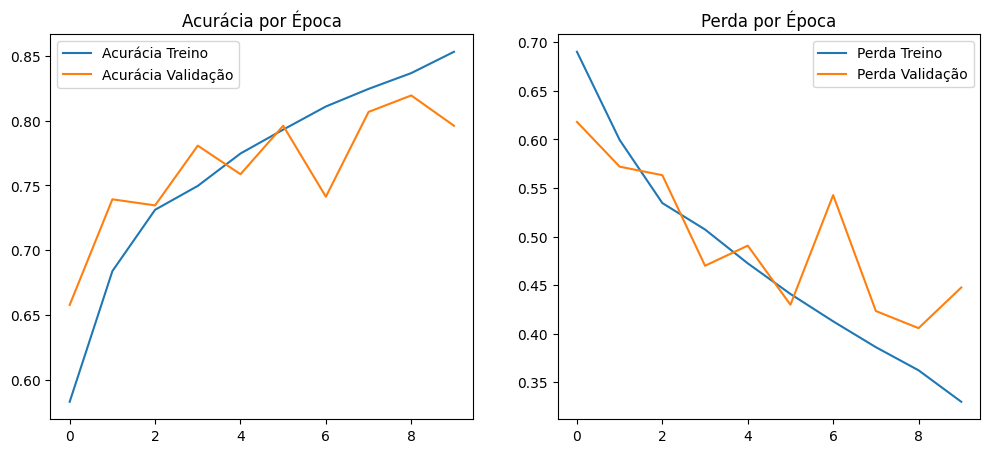

Saving Da Vinci_colab.jpg to Da Vinci_colab.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Da Vinci_colab.jpg é um gato.


In [3]:
import os
import random
import shutil
import zipfile
import urllib.request
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# CONFIGURAÇÃO DO DATASET
# ---------------------------
BASE_DIR = "/tmp"
ZIP_FILE = os.path.join(BASE_DIR, "gatos-e-cachorros.zip")
DATASET_DIR = os.path.join(BASE_DIR, "PetImages")
DATASET_URL = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"

# Baixar o dataset se não existir
if not os.path.exists(ZIP_FILE):
    print("Baixando o dataset...")
    urllib.request.urlretrieve(DATASET_URL, ZIP_FILE)
    print("Download concluído!")
else:
    print("Arquivo ZIP já existe.")

# Extrair o dataset se não estiver extraído
if not os.path.exists(DATASET_DIR):
    print("Extraindo o dataset...")
    with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
        zip_ref.extractall(BASE_DIR)
    print("Extração concluída!")
else:
    print("Dataset já foi extraído.")

# Definir os diretórios de origem para gatos e cachorros
DIR_GATOS_ORIGEM = os.path.join(DATASET_DIR, "Cat")
DIR_CACHORROS_ORIGEM = os.path.join(DATASET_DIR, "Dog")

# Verificar se os diretórios de origem existem
if not os.path.exists(DIR_GATOS_ORIGEM):
    raise FileNotFoundError(f"Diretório não encontrado: {DIR_GATOS_ORIGEM}")
if not os.path.exists(DIR_CACHORROS_ORIGEM):
    raise FileNotFoundError(f"Diretório não encontrado: {DIR_CACHORROS_ORIGEM}")

# ---------------------------
# CRIAÇÃO DOS DIRETÓRIOS DE TREINO E TESTE
# ---------------------------
DEST_DIR = os.path.join(BASE_DIR, "gatos-vs-cachorros")
DIR_GATOS_TREINO = os.path.join(DEST_DIR, "treino", "gatos")
DIR_GATOS_TESTE = os.path.join(DEST_DIR, "teste", "gatos")
DIR_CACHORROS_TREINO = os.path.join(DEST_DIR, "treino", "cachorros")
DIR_CACHORROS_TESTE = os.path.join(DEST_DIR, "teste", "cachorros")

def dividir_dados(origem, treino, teste, proporcao):
    """
    Divide os arquivos do diretório 'origem' em conjuntos de treino e teste,
    copiando-os para os diretórios 'treino' e 'teste' de acordo com a proporção informada.
    """
    os.makedirs(treino, exist_ok=True)
    os.makedirs(teste, exist_ok=True)

    arquivos = [f for f in os.listdir(origem) if os.path.getsize(os.path.join(origem, f)) > 0]
    if not arquivos:
        raise ValueError(f"Nenhum arquivo válido encontrado em {origem}.")

    random.shuffle(arquivos)
    tamanho_treino = int(len(arquivos) * proporcao)
    conjunto_treino = arquivos[:tamanho_treino]
    conjunto_teste = arquivos[tamanho_treino:]

    for arquivo in conjunto_treino:
        shutil.copyfile(os.path.join(origem, arquivo), os.path.join(treino, arquivo))
    for arquivo in conjunto_teste:
        shutil.copyfile(os.path.join(origem, arquivo), os.path.join(teste, arquivo))

    print(f"Divisão concluída para {origem}: {len(conjunto_treino)} para treino, {len(conjunto_teste)} para teste.")

# Dividir os dados (usando 90% para treino)
dividir_dados(DIR_GATOS_ORIGEM, DIR_GATOS_TREINO, DIR_GATOS_TESTE, 0.9)
dividir_dados(DIR_CACHORROS_ORIGEM, DIR_CACHORROS_TREINO, DIR_CACHORROS_TESTE, 0.9)

# ---------------------------
# CRIAÇÃO E TREINAMENTO DO MODELO
# ---------------------------
modelo = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
modelo.compile(optimizer=RMSprop(learning_rate=0.001),
               loss='binary_crossentropy',
               metrics=['accuracy'])
print("Modelo compilado.")

# Geradores de dados (normalizando as imagens e redimensionando para 150x150)
DIR_TREINO = os.path.join(DEST_DIR, "treino")
DIR_TESTE = os.path.join(DEST_DIR, "teste")

gerador_treino = ImageDataGenerator(rescale=1.0/255.)
gerador_validacao = ImageDataGenerator(rescale=1.0/255.)

gerador_treino = gerador_treino.flow_from_directory(
    DIR_TREINO,
    batch_size=250,
    class_mode='binary',
    target_size=(150,150)
)
gerador_validacao = gerador_validacao.flow_from_directory(
    DIR_TESTE,
    batch_size=250,
    class_mode='binary',
    target_size=(150,150)
)

# Treinamento do modelo
historico = modelo.fit(
    gerador_treino,
    epochs=10,
    steps_per_epoch=100,
    validation_data=gerador_validacao,
    validation_steps=6
)

# Plotar as métricas de treinamento
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(historico.history['accuracy'], label='Acurácia Treino')
plt.plot(historico.history['val_accuracy'], label='Acurácia Validação')
plt.title('Acurácia por Época')
plt.legend()

plt.subplot(1,2,2)
plt.plot(historico.history['loss'], label='Perda Treino')
plt.plot(historico.history['val_loss'], label='Perda Validação')
plt.title('Perda por Época')
plt.legend()
plt.show()

# ---------------------------
# CLASSIFICAÇÃO DE UMA IMAGEM ENVIADA PELO USUÁRIO (NO COLAB)
# ---------------------------
try:
    from google.colab import files
    uploaded = files.upload()

    for nome_arquivo in uploaded.keys():
        caminho_img = os.path.join('/content', nome_arquivo)
        img = image.load_img(caminho_img, target_size=(150,150))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        resultado = modelo.predict(img_array)
        classe = "cachorro" if resultado[0] > 0.5 else "gato"
        print(f"{nome_arquivo} é um {classe}.")
except ImportError:
    print("O upload de arquivos está disponível apenas no Google Colab.")
